In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from model import *
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 300
K = 3
D = 2
## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 16
NUM_HIDDEN_LOCAL = 64
STAT_SIZE = 8
## Training Parameters
BATCH_SIZE = 50
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
PATH = 'ag-sis-mu-rad-v1'

In [3]:
Xs = torch.from_numpy(np.load('rings_varying_radius/obs.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
enc_mu_rad, enc_z, optimizer = initialize(NUM_HIDDEN_GLOBAL, STAT_SIZE, NUM_HIDDEN_LOCAL, K, D, CUDA, DEVICE, LEARNING_RATE)

In [5]:
EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(DEVICE)
        eubos, elbos, esss = Eubo_ag_rad(enc_mu_rad, enc_z, obs, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, noise_sigma=0.05, device=DEVICE)
        ## gradient step
        eubos.mean().backward()
        optimizer.step()
        EUBO += eubos[-1].item()
        ELBO += elbos[-1].item()
        ESS += esss[-1].item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))


epoch=0, EUBO=-115911.582, ELBO=-614337.880, ESS=2.327 (13s)
epoch=1, EUBO=-55803.613, ELBO=-380552.429, ESS=2.402 (12s)
epoch=2, EUBO=-34697.336, ELBO=-203470.307, ESS=2.416 (13s)
epoch=3, EUBO=-25034.181, ELBO=-153118.499, ESS=2.598 (13s)
epoch=4, EUBO=-21695.189, ELBO=-122658.962, ESS=2.956 (13s)
epoch=5, EUBO=-20106.150, ELBO=-100724.629, ESS=3.237 (13s)
epoch=6, EUBO=-19137.263, ELBO=-85167.304, ESS=3.447 (13s)
epoch=7, EUBO=-17599.369, ELBO=-75208.769, ESS=3.622 (13s)
epoch=8, EUBO=-16973.960, ELBO=-69373.432, ESS=3.745 (13s)
epoch=9, EUBO=-16752.763, ELBO=-66403.433, ESS=3.829 (13s)
epoch=10, EUBO=-16097.248, ELBO=-60199.369, ESS=3.919 (13s)
epoch=11, EUBO=-16632.111, ELBO=-59505.194, ESS=3.984 (13s)
epoch=12, EUBO=-16832.489, ELBO=-57877.344, ESS=4.049 (13s)
epoch=13, EUBO=-17598.764, ELBO=-57480.004, ESS=4.077 (13s)
epoch=14, EUBO=-16860.950, ELBO=-51415.063, ESS=4.143 (13s)
epoch=15, EUBO=-16395.972, ELBO=-46714.346, ESS=4.201 (13s)
epoch=16, EUBO=-15022.540, ELBO=-38836.758,

KeyboardInterrupt: 

CPU times: user 5.06 s, sys: 19.9 ms, total: 5.08 s
Wall time: 5.07 s


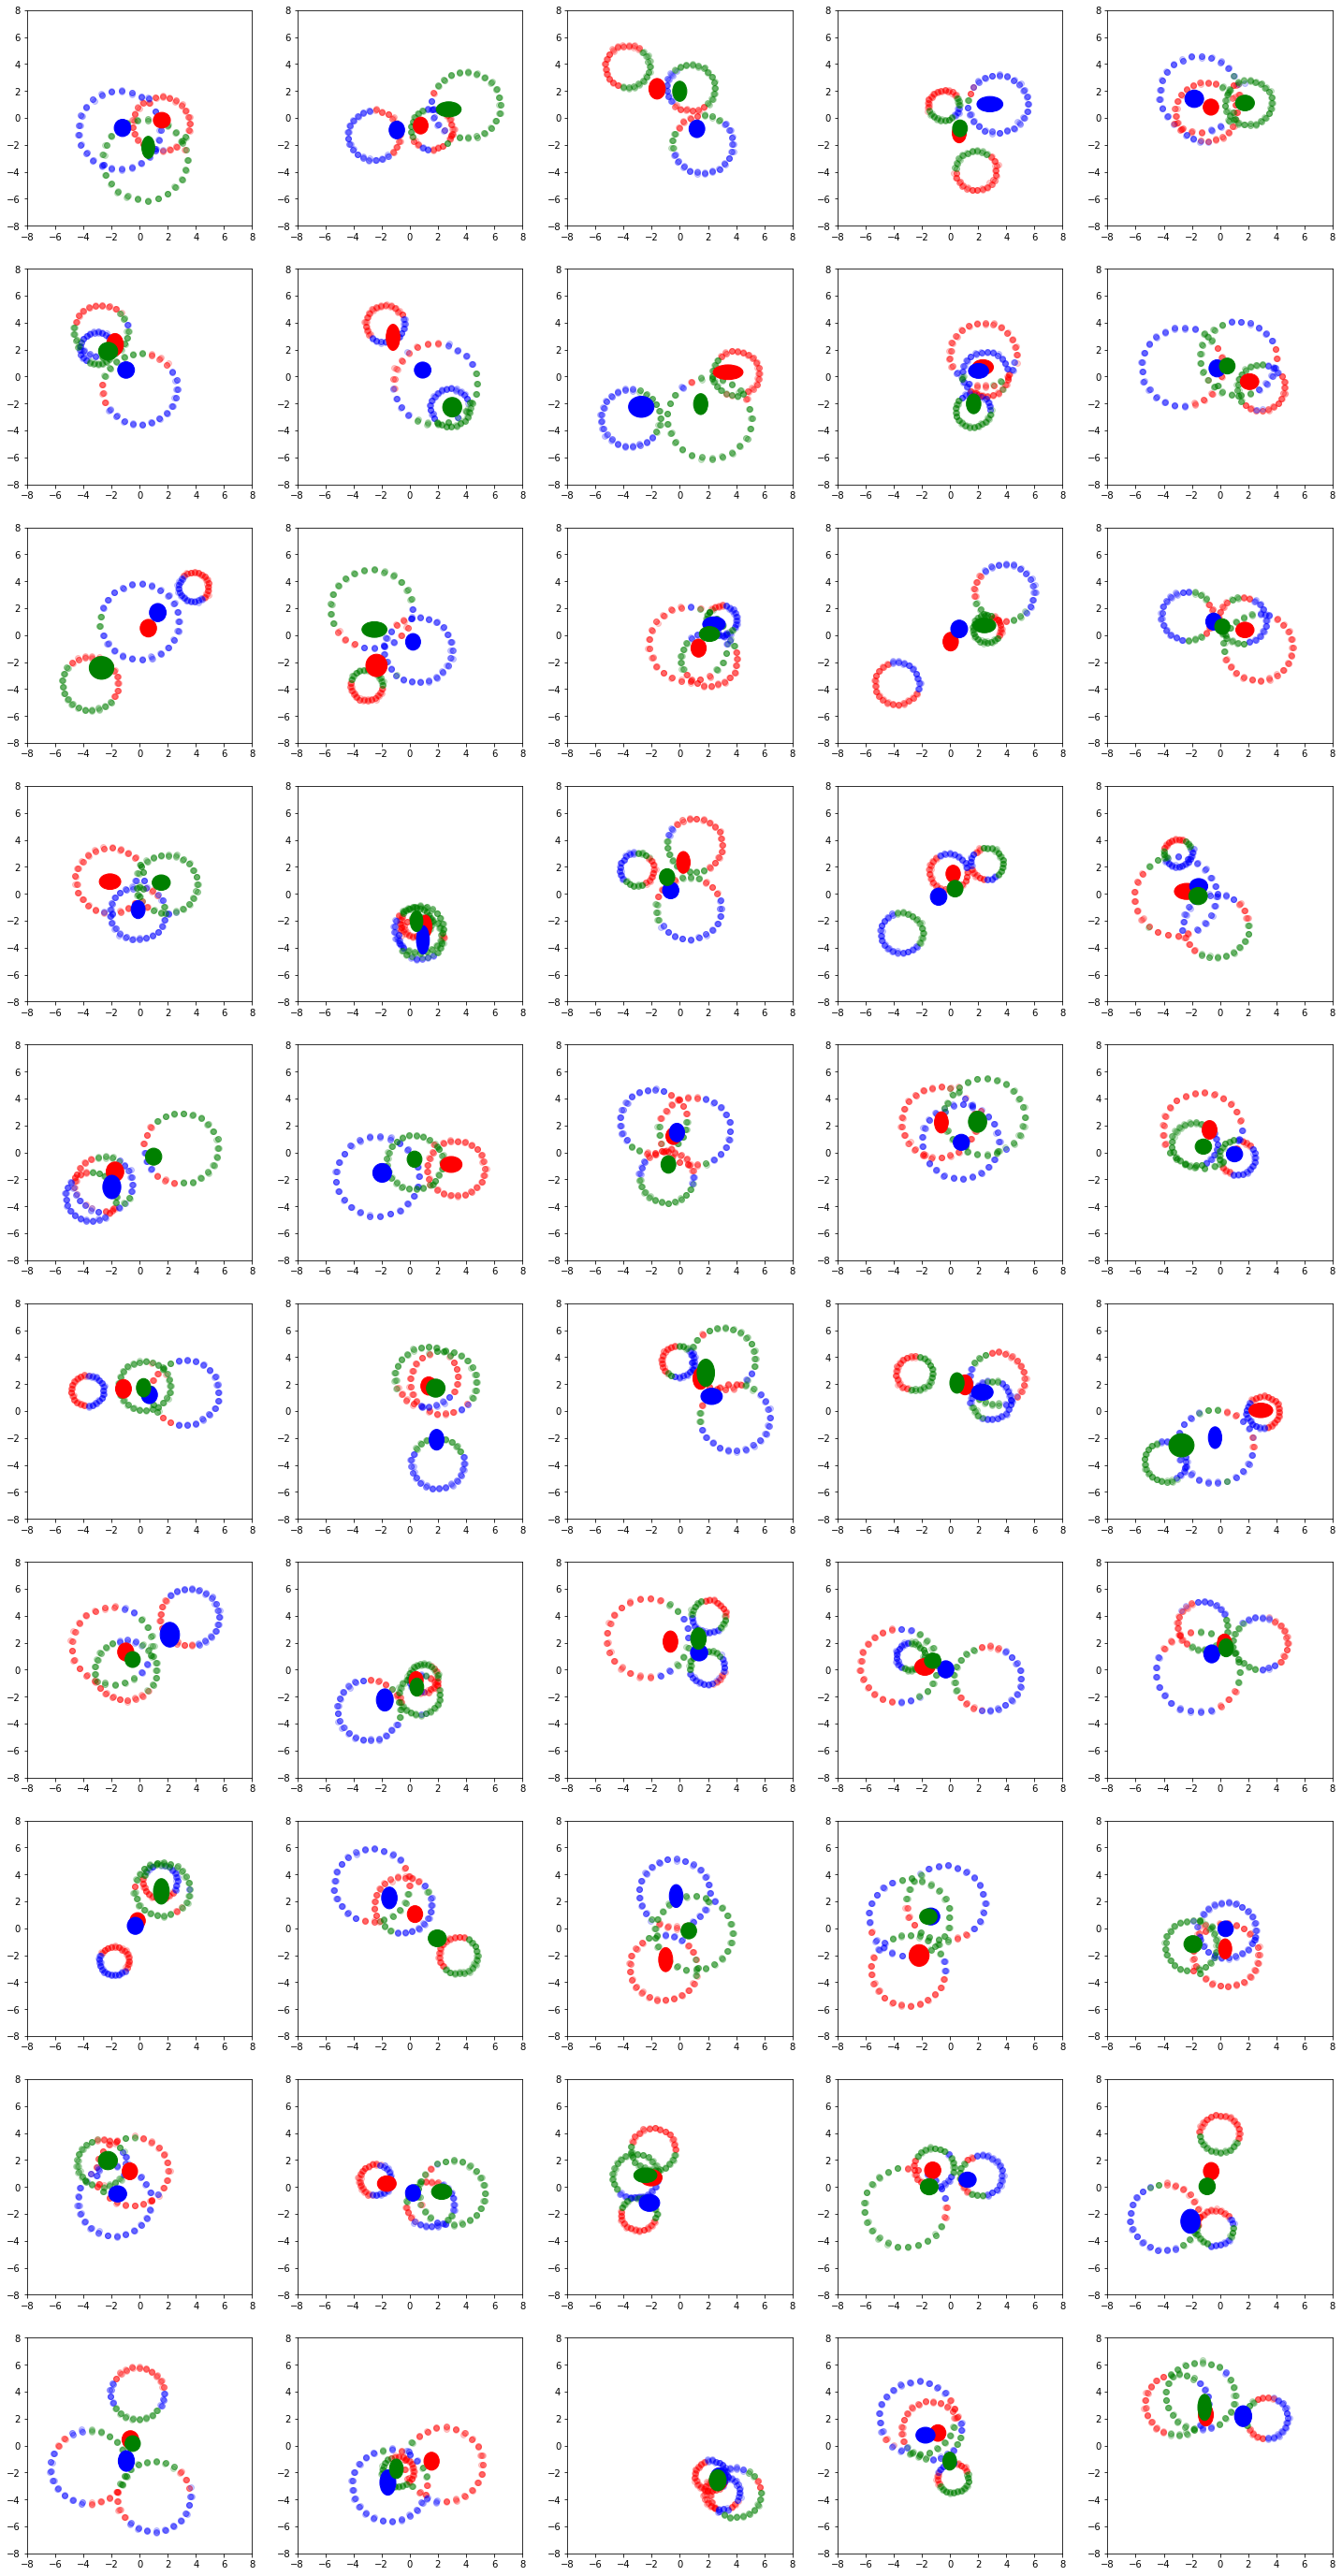

In [13]:
BATCH_SIZE_TEST = 50
def sample_single_batch(num_seqs, Xs, sample_size, batch_size, CUDA, device):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(device)
    return obs

def test(enc_mu_rad, enc_z, obs, N, K, D, mcmc_size, sample_size, batch_size, noise_sigma, device):
    """
    initialize z
    learn both mean and radius

    """
    p_init_z = cat(enc_z.prior_pi)
    states = p_init_z.sample((sample_size, batch_size, N,))
    log_p_z = p_init_z.log_prob(states)## S * B * N
    log_q_z = p_init_z.log_prob(states)

    for m in range(mcmc_size):
        if m != 0:
            states = resample_states(states, weights_local)
        q_eta, p_eta = enc_mu_rad(obs, states, K, sample_size, batch_size)
        log_q_eta = q_eta['means'].log_prob.sum(-1) + q_eta['radius'].log_prob.sum(-1)
        log_p_eta = p_eta['means'].log_prob.sum(-1) + p_eta['radius'].log_prob.sum(-1)
        obs_mu = q_eta['means'].value
        obs_rad = q_eta['radius'].value
        log_obs_k = True_Log_likelihood(obs, states, obs_mu, obs_rad, K, D, noise_sigma, device, cluster_flag=True)
        log_weights_global = log_obs_k + log_p_eta - log_q_eta
        weights_global = F.softmax(log_weights_global, 0).detach()
        ## resample mu
        obs_mu, obs_rad = resample_eta(obs_mu, obs_rad, weights_global)
        ## update z -- cluster assignments
        q_z, p_z = enc_z(obs, obs_mu, obs_rad, N, sample_size, batch_size, noise_sigma, device)
        log_p_z = p_z['zs'].log_prob
        log_q_z = q_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value
        log_obs_n = True_Log_likelihood(obs, states, obs_mu, obs_rad, K, D, noise_sigma, device, cluster_flag=False)
        log_weights_local = log_obs_n + log_p_z - log_q_z
        weights_local = F.softmax(log_weights_local, 0).detach()

    return q_eta, q_z

def plot_samples(obs, q_eta, q_z, K, batch_size, PATH):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(25,50))
    xs = obs[0].cpu()
    mu_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
    mu_sigma = q_eta['means'].dist.scale[0].cpu().data.numpy()
    zs = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b]
        z = zs[b]
        mu_mu_b = mu_mu[b]
        mu_sigma_b = mu_sigma[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(mu_sigma_b[k]**2)
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
            plot_cov_ellipse(cov=cov_k, pos=mu_mu_b[k], nstd=2, ax=ax, alpha=1.0, color=colors[k])
        ax.set_ylim([-8, 8])
        ax.set_xlim([-8, 8])
    plt.savefig('results/modes-' + PATH + '.svg')
    
obs = sample_single_batch(NUM_SEQS, Xs, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE)
q_eta, q_z = test(enc_mu_rad, enc_z, obs, N, K, D, 100, SAMPLE_SIZE, BATCH_SIZE_TEST, noise_sigma=0.05, device=DEVICE)
%time plot_samples(obs, q_eta, q_z, K, BATCH_SIZE_TEST, PATH)